<a href="https://colab.research.google.com/github/khp53/EssenceExtract---Summarize-a-long-article-using-BART/blob/main/EssenceExtract_Summarize_a_long_article_using_BART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

In [2]:
!pip install wordcloud

In [3]:
!pip install Counter

In [4]:
!pip3 install torch torchvision torchaudio

In [5]:
!pip install accelerate -U

In [6]:
!pip install transformers[torch]

In [7]:
!pip install rouge-score==0.1.2

In [8]:
!pip install tensorboard

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from datasets import load_dataset
import itertools
from collections import Counter

In [10]:
dataset = load_dataset("cnn_dailymail", '3.0.0')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})


In [12]:
print(dataset['train'][:3])

{'article': ['LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office cha

In [13]:
article_lengths = [len(entry['article']) for entry in dataset['train']]
summary_lengths = [len(entry['highlights']) for entry in dataset['train']]

In [14]:
# Calculate and print average lengths
print("Average length of articles:", np.mean(article_lengths))
print("Average length of summaries:", np.mean(summary_lengths))

Average length of articles: 4033.6617220397543
Average length of summaries: 294.7703900554834


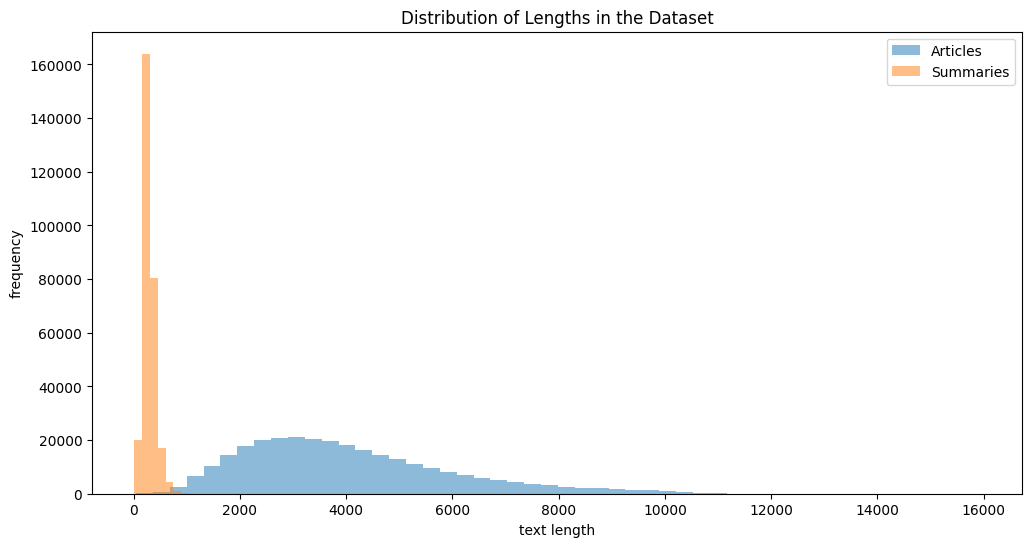

In [15]:
plt.figure(figsize=(12, 6))
plt.hist(article_lengths, bins=50, alpha=0.5, label='Articles')
plt.hist(summary_lengths, bins=50, alpha=0.5, label='Summaries')
plt.title('Distribution of Lengths in the Dataset')
plt.xlabel('text length')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [16]:
words = (word for entry in dataset['train']['article'] for word in entry.split())

word_counts = Counter(words) # counter libray was used for this

print(word_counts.most_common(10))

[('the', 9791515), ('to', 5332131), ('of', 4554342), ('a', 4487198), ('and', 4480885), ('in', 3825318), ('.', 3071328), ('was', 1884632), ('for', 1779885), ('that', 1717024)]


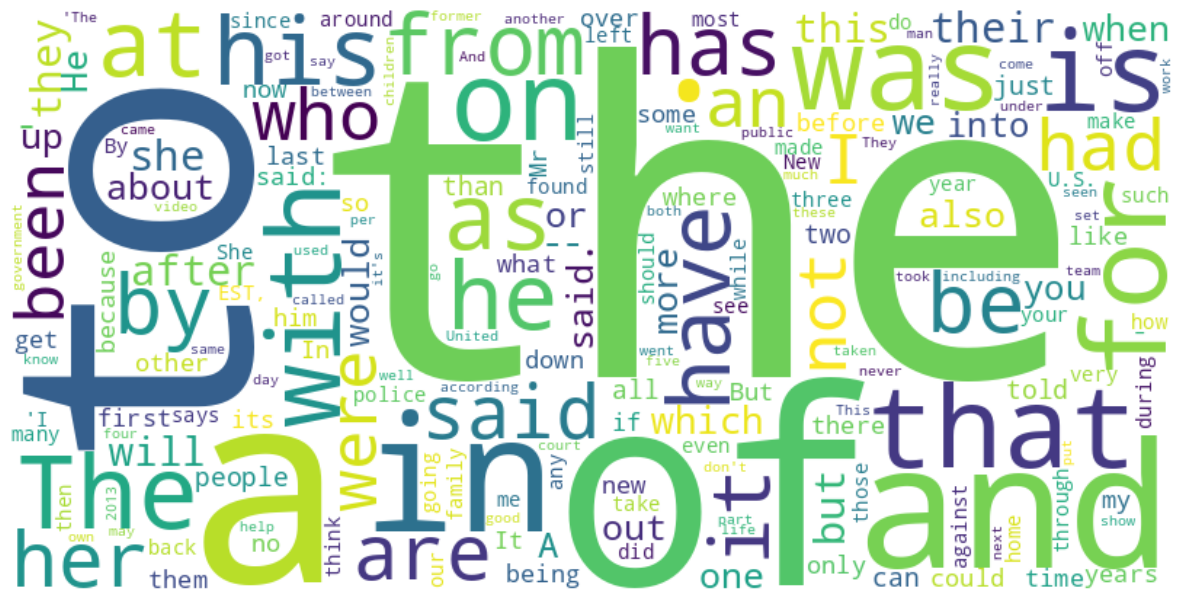

In [17]:
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate_from_frequencies(word_counts)
# word cloud library was used for this
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
import torch
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
from transformers.integrations import TensorBoardCallback
from rouge_score import rouge_scorer

In [19]:
dataset = load_dataset("cnn_dailymail", '3.0.0')
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})


In [20]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

In [21]:
def preprocess_data(examples):
    inputs = [doc for doc in examples['article']]

    # Hyperparameters: max_length=1024: Maximum length of the input sequences during tokenization. This limits the number of tokens in the input articles.
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length")

    # Prepare labels
    with tokenizer.as_target_tokenizer():
        # Hyperparameters: max_length=128: Maximum length of the target sequences during tokenization. This limits the number of tokens in the target summaries.
        labels = tokenizer(examples['highlights'], max_length=32, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [22]:
tokenized_datasets = dataset.map(preprocess_data, batched=True, batch_size=1024)

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

**Token Length Distribution:**

This visualization helps in understanding the distribution of token lengths after tokenization, which can be useful for setting appropriate maximum sequence lengths for your model.

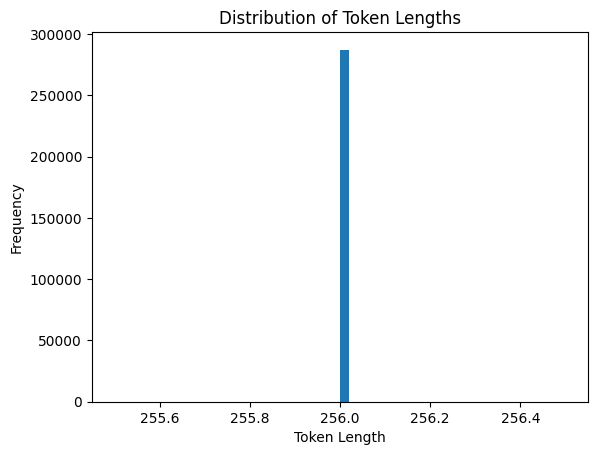

In [23]:
token_lengths = [len(example['input_ids']) for example in tokenized_datasets['train']]
plt.hist(token_lengths, bins=50)
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths')
plt.show()

In [24]:
small_train_dataset = tokenized_datasets["train"].select(range(500))
small_test_dataset = tokenized_datasets["test"].select(range(500))
small_val_dataset = tokenized_datasets["validation"].select(range(500))

# Bidirectional and Auto-Regressive Transformers model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     x = torch.ones(1, device=mps_device)
#     print(x)
# else:
#     print("MPS device not found")

# model.to(mps_device)
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory for model checkpoints
    num_train_epochs=3,              # total number of training epochs - model hyperparameter
    per_device_train_batch_size=8,   # batch size per device during training - model hyperparameter
    per_device_eval_batch_size=8,    # batch size for evaluation - model hyperparameter
    fp16=True,                       # use mixed precision training - model hyperparameter
    warmup_steps=100,                # number of warmup steps for learning rate scheduler - model hyperparameter
    weight_decay=0.01,               # strength of weight decay - model hyperparameter
    logging_dir='./logs',            # directory for storing logs - model hyperparameter
    logging_steps=5,                 # log & save weights each logging_steps - model hyperparameter
    evaluation_strategy="steps",     # evaluate each `logging_steps` - model hyperparameter
    eval_steps=10,                   # Evaluate every 100 steps
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',  # evaluation loss was choosen
    report_to="tensorboard"
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated Huggingface Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=small_train_dataset,   # training dataset
    eval_dataset=small_val_dataset,      # evaluation dataset
    callbacks=[TensorBoardCallback()]
)

# Start training
trainer.train()

test_results = trainer.evaluate(small_test_dataset)
print(test_results)

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
You are adding a <class 'transformers.integrations.integration_utils.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback


Step,Training Loss,Validation Loss
10,3.292300,3.444246
20,2.717200,3.021129
30,2.226700,2.712782
40,2.090100,2.501073
50,2.065600,2.381481
60,1.629800,2.377560
70,1.226300,2.421036
80,1.101100,2.478880
90,1.119600,2.541532
100,1.329400,2.468882


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


{'eval_loss': 2.6837072372436523, 'eval_runtime': 4.8969, 'eval_samples_per_second': 102.106, 'eval_steps_per_second': 12.865, 'epoch': 3.0}


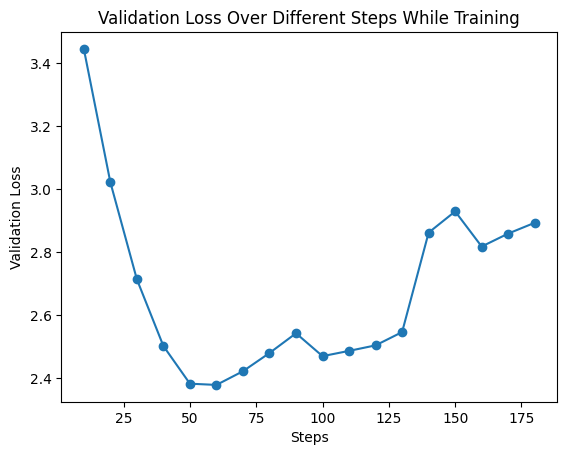

In [29]:
steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180]
validation_losses = [3.444246, 3.021129, 2.712782, 2.501073, 2.381481, 2.377560, 2.421036, 2.478880, 2.541532, 2.468882, 2.485641, 2.503154, 2.545295, 2.861091, 2.928440, 2.816897, 2.858085, 2.892346]

plt.plot(steps, validation_losses, marker='o')
plt.xlabel('Steps')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Different Steps While Training')
plt.show()

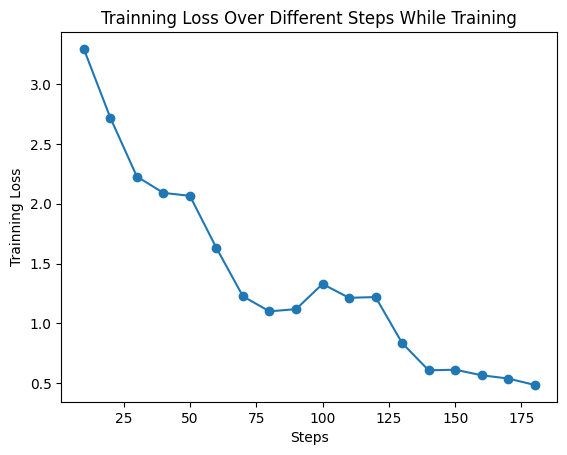

In [31]:
steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180]
trainning_losses = [3.292300, 2.717200, 2.226700, 2.090100, 2.065600, 1.629800, 1.226300, 1.101100, 1.119600, 1.329400, 1.214100, 1.220200, 0.836500, 0.608500, 0.613800, 0.567300, 0.540000, 0.486700]

plt.plot(steps, trainning_losses, marker='o')
plt.xlabel('Steps')
plt.ylabel('Trainning Loss')
plt.title('Trainning Loss Over Different Steps While Training')
plt.show()

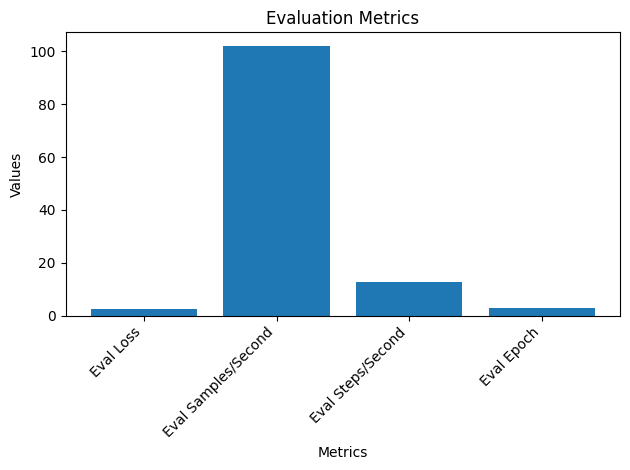

In [34]:
data = {'Eval Loss': test_results.get('eval_loss', 0.0),
        'Eval Samples/Second': test_results.get('eval_samples_per_second', 0.0),
        'Eval Steps/Second': test_results.get('eval_steps_per_second', 0.0),
        'Eval Epoch': test_results.get('epoch', 0.0)}

metrics = list(data.keys())
values = list(data.values())

plt.bar(metrics, values)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [35]:
# Load the trained model and tokenizer
model_path = './results/checkpoint-189'
model = BartForConditionalGeneration.from_pretrained(model_path)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [36]:
# Function to generate summaries
def generate_summary_BART(text):
    inputs = tokenizer(text, max_length=256, return_tensors='pt', truncation=True, padding=True).to('cuda')
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=64, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [37]:
model.to('cuda')
# Calculate ROUGE scores for the test dataset
rouge_scores = []
for i, example in enumerate(tokenized_datasets["test"]):
    if i >= 500:
        break
    article = example['article']
    reference_summary = example['highlights']
    generated_summary = generate_summary_BART(article)
    scores = scorer.score(reference_summary, generated_summary)
    rouge_scores.append(scores)



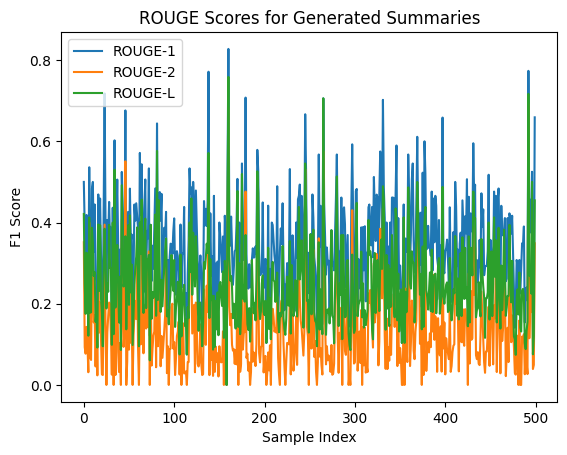

Average ROUGE-1 F1 Score: 0.3499456510204203
Average ROUGE-2 F1 Score: 0.13921177144562888
Average ROUGE-L F1 Score: 0.24929811443338218


In [38]:
# Extract ROUGE-1, ROUGE-2, and ROUGE-L scores
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rougeL_scores = [score['rougeL'].fmeasure for score in rouge_scores]

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the scores
ax.plot(rouge1_scores, label='ROUGE-1')
ax.plot(rouge2_scores, label='ROUGE-2')
ax.plot(rougeL_scores, label='ROUGE-L')

# Set labels and title
ax.set_xlabel('Sample Index')
ax.set_ylabel('F1 Score')
ax.set_title('ROUGE Scores for Generated Summaries')
ax.legend()

# Display the plot
plt.show()

# Calculate and print average scores
avg_rouge1_bart = np.mean(rouge1_scores)
avg_rouge2_bart = np.mean(rouge2_scores)
avg_rougeL_bart = np.mean(rougeL_scores)

print("Average ROUGE-1 F1 Score:", avg_rouge1_bart)
print("Average ROUGE-2 F1 Score:", avg_rouge2_bart)
print("Average ROUGE-L F1 Score:", avg_rougeL_bart)

**Compare with PEGASUS Model**

In [39]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

In [40]:
model_name = "google/pegasus-cnn_dailymail"
pegasus_tokenizer = PegasusTokenizer.from_pretrained(model_name)
pegasus_model = PegasusForConditionalGeneration.from_pretrained(model_name).to('cuda')

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [41]:
def generate_summary(text):
    inputs = pegasus_tokenizer(text, max_length=256, return_tensors='pt', truncation=True, padding=True).to('cuda')
    summary_ids = pegasus_model.generate(inputs['input_ids'], num_beams=4, max_length=64, early_stopping=True)
    return pegasus_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [42]:
pegasus_model.to('cuda')
pegasus_rouge_scores = []
for i, example in enumerate(tokenized_datasets["test"]):
    if i >= 500:
        break
    article = example['article']
    reference_summary = example['highlights']
    generated_summary = generate_summary(article)
    scores = scorer.score(reference_summary, generated_summary)
    pegasus_rouge_scores.append(scores)

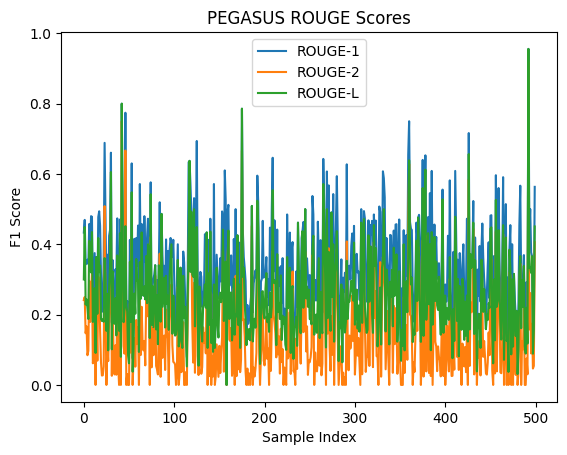

In [43]:
pegasus_rouge1_1 = [score['rouge1'].fmeasure for score in pegasus_rouge_scores]
pegasus_rouge2_1 = [score['rouge2'].fmeasure for score in pegasus_rouge_scores]
pegasus_rougeL_1 = [score['rougeL'].fmeasure for score in pegasus_rouge_scores]

fig2, ax2 = plt.subplots()
ax2.plot(pegasus_rouge1_1, label='ROUGE-1')
ax2.plot(pegasus_rouge2_1, label='ROUGE-2')
ax2.plot(pegasus_rougeL_1, label='ROUGE-L')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('F1 Score')
ax2.set_title('PEGASUS ROUGE Scores')
ax2.legend()
plt.show()

In [44]:
avg_rouge1_pegasus = np.mean(pegasus_rouge1_1)
avg_rouge2_pegasus = np.mean(pegasus_rouge2_1)
avg_rougeL_pegasus = np.mean(pegasus_rougeL_1)

print("Average ROUGE-1 F1 Score PEGASUS:", avg_rouge1_pegasus)
print("Average ROUGE-2 F1 Score PEGASUS:", avg_rouge2_pegasus)
print("Average ROUGE-L F1 Score PEGASUS:", avg_rougeL_pegasus)

Average ROUGE-1 F1 Score PEGASUS: 0.3421315186754162
Average ROUGE-2 F1 Score PEGASUS: 0.14741406784278432
Average ROUGE-L F1 Score PEGASUS: 0.2571135957606412


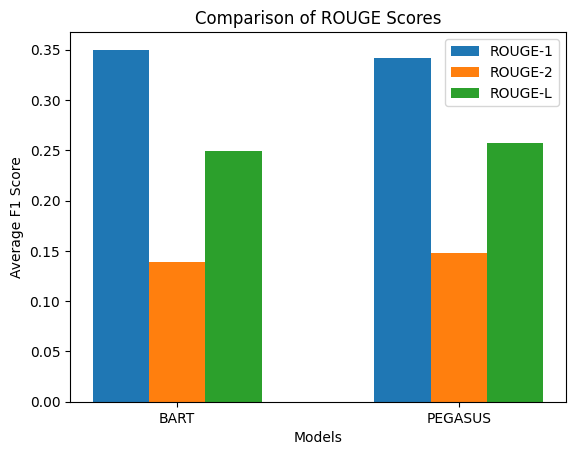

In [45]:
models = ['BART', 'PEGASUS']
rouge1 = [avg_rouge1_bart, avg_rouge1_pegasus]
rouge2 = [avg_rouge2_bart, avg_rouge2_pegasus]
rougeL = [avg_rougeL_bart, avg_rougeL_pegasus]

fig, ax = plt.subplots()
bar_width = 0.2
index = np.arange(len(models))

ax.bar(index, rouge1, bar_width, label='ROUGE-1')
ax.bar(index + bar_width, rouge2, bar_width, label='ROUGE-2')
ax.bar(index + 2 * bar_width, rougeL, bar_width, label='ROUGE-L')

ax.set_xlabel('Models')
ax.set_ylabel('Average F1 Score')
ax.set_title('Comparison of ROUGE Scores')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(models)
ax.legend()

plt.show()

In [46]:
text= "In early August, construction crews will begin work to upgrade storm sewer infrastructure on University Avenue. Upgrades are expected to be completed by October 2024. The impacted area extends from approximately 118 University Avenue to the north side of Prince Philip Drive. The new storm sewer will be installed through the intersection, crossing all lanes of Prince Philip Drive. Lane reductions, diversions, and possible detours are expected to cause traffic delays. Pedestrian access will be maintained during construction, and the public is asked to follow all posted signage in and near the construction zones. The City of St. John’s will provide updates on traffic interruptions and progress throughout the duration of the project."

In [47]:
result = generate_summary_BART(text)
print(result)

Construction crews will begin work to upgrade storm sewer infrastructure on University Avenue in early August.
New storm sewer will be installed through the intersection, crossing all lanes of Prince Philip Drive.
Lane reductions, diversions, and possible detours are expected to cause traffic delays.


In [48]:
result_pegasus = generate_summary(text)
print(result_pegasus)

Upgrades to storm sewer infrastructure on University Avenue are expected to be completed by October 2024.<n>Lane reductions, diversions, and possible detours are expected to cause traffic delays.<n>Pedestrian access will be maintained during construction.


**Mount the google drive**

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Pickle the fine-tuned BART model**

In [52]:
import pickle

with open('/content/drive/My Drive/ACC Pickled Model/trained_bart_model.pkl', 'wb') as file:
    pickle.dump(model, file)